# Explanation

The **backpropagation** algorithm, originally introduced as the **generalized delta rule**, has remained the core of all deep learning since it was introduced over 30 years ago.

Fully understanding how it works from first principles is essential to understanding the rest of progress in deep learning. Thinking in terms of how the loss function incentives the network to learn and how gradients flow back through the network is critical to understand future improvements to neural network architectures, optimization, and regularization.

This algorithm is what defines a neural network, and deep learning as a whole.

### Resources

Thankfully, there are great resources online to learn these fundamentals. These 2 are especially high quality and are required for anyone who hasn't watched them already.
- 3blue1brown's neural networks series - [Neural networks](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=lNICwc8Q1g5AFRT1)
- Andrej Karpathy's introduction - [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)

I'd highly recommend anyone who hasn't to go through and implement Andrej Karpathy's introduction to backpropagation, even people who are familiar with how neural networks work in depth but learned through a different method.

Karpathy's explanation covers how deep learning libraries like PyTorch and JAX work under the hood, and by extension how feed-forward and back-propagation work in depth.

### Intuition

Training neural networks happens in three distinct steps.
1. Inputs are fed-forward through the network as the network performs computations to predict the output.
2. The loss is calculated based on the networks predictions and the actual expected output.
3. The loss is propagated backward through the network, gradients of the loss with respect to each parameter are calculated, and then each parameter is updated slightly in the direction of improvement via an optimization function.

This simple process provides the basis for all the complexity in modern networks, and these steps are still true.

# My Notes

## 📜 [Learning Internal Representations by Error Propagation](https://stanford.edu/~jlmcc/papers/PDP/Volume%201/Chap8_PDP86.pdf)

> There is always a recording (ie. internal representation) of the input patterns in the hidden units in which the similarity of the patterns among the hidden units can support any required mapping from the input to the output units.
>

> If we have the right connections from input units to a large enough set of hidden units, we can always find a representation that will perform any mapping from input to output through these hidden units.
>

A feed-forward network with one hidden layer is technically capable of modeling any distribution if given sufficient size. In reality, this is impractical and stops being true very quickly due to other constraints, but it’s an important theoretical consideration.

### The Generalized Delta Rule

> The learning procedure we propose involves the presentation of a set of pairs of input and output patterns. The system first uses the input vector to produce its own output vector and then compares this with the *desired output*, or *target* vector.
>

This generalized delta rule is the introduction of the backpropagation learning algorithm used in all neural networks today.

> If there is no difference, no learning takes place. Otherwise the weights are changed to reduce the difference.
>

This introduces the process of calculating the loss, then calculating the gradient of this loss with respect to the parameters, and then incrementing the parameters in the correct direction.

> The rule for changing weights following presentation of input/output pair $p$ is given by
>

$$
\Delta_pw_{ji} = n(t_{pj} - o_{pj}) i_{pi} = n\delta_{pj}i_{pi}
$$

> It is useful to see that for linear units it minimizes the squares of the differences between the actual and the desired output values summed over the output units and all pairs of input/output vectors.
>

This is the introduction of the mean squared error for loss calculation.

> To compute $\delta_{pj} = - \frac{\partial E_p}{\partial net_{pj}}$, we apply the chain rule to write this partial derivative as the product of two factors, one factor reflecting the change in error as a function of the output of the unit and one reflecting the change in the output as a function of changes in the input.
>

> The application of the generalized delta rule, thus, involves two phases: during the first phase the input is presented and propagated forward through the network to compute the output value $o_{pj}$ for each unit. This output is then compared with the targets, resulting in an error signal $\sigma_{pj}$ for each output unit.
>

> The second phase involves a backward pass through the network (analogous to the initial forward pass) during which the error signal is passed to each unit in the network and the appropriate weight changes are made.
>

First we feed-forward data through the network to compute a prediction. Then we calculate loss based on the mean-squared error with the outputs. Then we back-propagate the loss, calculating gradients and updating parameters.

### Simulation Results

> We now have a learning procedure which could, in principle, evolve a set of weights to produce an arbitrary mapping from input to output.
>

> We need a continuous, nonlinear activation function. In most of our experiments we have used the *logistic* activation function.
>

The activation has to be differentiable in order to support the generalized delta rule, and it needs to introduce a nonlinearity to increase the neural networks capacity to model complex problems.

> True gradient descent requires that infinitesimal steps be taken […]. For practical purposes, we choose a learning rate that is as large as possible without leading to oscillation. This offers the most rapid learning.
>

### Recurrent Nets

> There is, for every recurrent network, a feedforward network with identical behavior (over a finite period of time).
>

> The major problem with [recurrent neural networks] is the memory required. […] Each unit must somehow record the sequence of activation values through which it was driven during the original processing. It is not entirely clear how such a mechanism could be implemented in the brain.
>

They give the examples of *learning to be a shift register* and *learning to complete sequences* as the originally interesting problems concerning recurrent neural networks.

### Conclusion

> We believe that we have answered Minsky and Papert’s challenge and *have* found a learning result sufficiently powerful to demonstrate that their pessimism about learning in multilayer machines was misplaced.
>

Seeing the skepticism in hindsight is a lesson for the future as well. Especially when you can sympathize with the skeptical side (as a thought experiment) and understand what would lead them to their (consensus) beliefs, you can see what it would take to have conviction in the true (but non-consensus) reality that deep learning offers promise.

> One way to view the procedure we have been describing is as a parallel computer that, having been shown the appropriate input/output exemplars specifying some function, programs itself to compute that function in general.
>

> Finally, we should say that this work is not yet in a finished form.
>

Funny seeing a line like this in hindsight and knowing what this work in deep learning led to.

# Implementation

This implementation is based on Andrej Karpathy's micrograd tutorial ([the spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)), which is the best resource on the internet for building all the intuitions of how feed-forward networks and backpropagation work.

In [1]:
import math
import random

Here, we create a Value object equivalent to a value of a tensor in pytorch, which handles automatically creating an opgraph as we perform computatinos on it, and automatically handles backpropagation.

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data               # the actual value of the parameter (or data)
        self.grad = 0.0                # initialize gradients to 0
        self._backward = lambda: None  # configured when the Value object is a result of an operation
        self._prev = set(_children)    # the tree of parents
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # addition spreads the gradient back through to parents
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * - 1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # multiplication spreads the gradient back scaled by each weight
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')

        # gradient of raising to power
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        # gradient of exponentiation
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        # gradient of tanh
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        # gated relu gradient (important for sparse representations)
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        # create a topological sort of the operation graph
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # traverse the opgraph in reverse order (from loss to inputs) and backpropagate gradients
        # we can just call this recursively because we need to make sure that each parent
        # only gets the backward function called once
        self.grad = 1
        for v in reversed(topo):
            v._backward()

Using this object, we can create a pytorch like linear layer with neurons, and a full multi-layer perceptron feed-forward neural network that automatically configures the graph of operations and handles backpropagation.

In [3]:
# building up a single neuron from our Value objects
class Neuron:
    def __init__(self, nin, nonlin=True):
        # initialize a weight and bias
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        # g(w*x + b)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

# create a layer of neurons
class Layer:
    def __init__(self, nin, nout, **kwargs):
        # nin input neurons to this layer, and nout neurons in this layer
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# create an MLP network with a number of feed forward layers
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # last layer should not use relu
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
np.random.seed(1337)
random.seed(1337)

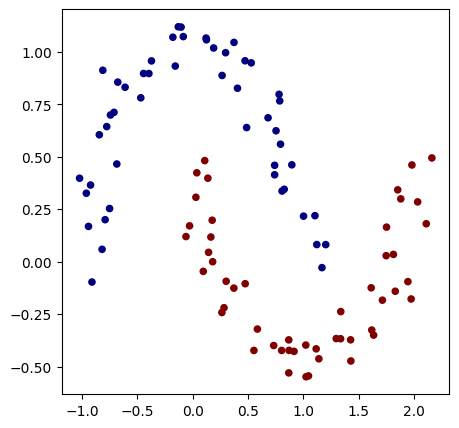

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [13]:
model = MLP(2, [16, 16, 1])

In [9]:
def loss(batch_size=None):
    # implement batching for sgd with Xb, yb
    if batch_size is None:
        Xb, yb = X, y
    else:
        # get batch_size number of indices of random elements
        ri = np.random.permutation(X.shape[0])[:batch_size]
        # get batch_size random elements
        Xb, yb = X[ri], y[ri]
    # create coordinate pairs of Value
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1.0 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4 # how much to penalize
    reg_loss = alpha * sum((p*p for p in model.parameters())) # compute penalty for L^2 norm on parameters
    total_loss = data_loss + reg_loss # add penalty (prefer lower weight/bias values)

    # accuracy
    accuracy = [1.0 if (yi > 0) == (scorei.data > 0) else 0.0 for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [14]:
# optimization
for k in range(20):
    # forward pass
    total_loss, acc = loss()

    # backward pass
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()

    # update
    learning_rate = 1.0 - 0.9*k/20 # decrease learning rate over time
    for p in model.parameters():
        p.data -= learning_rate * p.grad # increment in negative grad direction

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.5968898068523196, accuracy 19.0%
step 1 loss 0.5997450178762415, accuracy 81.0%
step 2 loss 1.6452553311661433, accuracy 50.0%
step 3 loss 2.6272195456628706, accuracy 50.0%
step 4 loss 0.6068047737717158, accuracy 79.0%
step 5 loss 0.442779003754614, accuracy 80.0%
step 6 loss 0.31478430225180837, accuracy 84.0%
step 7 loss 0.2827485634854347, accuracy 89.0%
step 8 loss 0.24232697532871667, accuracy 93.0%
step 9 loss 0.21671983071329362, accuracy 94.0%
step 10 loss 0.3853696430864055, accuracy 85.0%
step 11 loss 0.4161747104554607, accuracy 84.0%
step 12 loss 0.33083298689383583, accuracy 87.0%
step 13 loss 0.26093006675734326, accuracy 91.0%
step 14 loss 0.21275635313678276, accuracy 91.0%
step 15 loss 0.19234794694323767, accuracy 92.0%
step 16 loss 0.17768531913128238, accuracy 92.0%
step 17 loss 0.16591215066605636, accuracy 94.0%
step 18 loss 0.15706587255792506, accuracy 94.0%
step 19 loss 0.15068661664834065, accuracy 94.0%


Now with a fully trained network, we can visualize its decision boundary

(-1.548639298268643, 1.951360701731357)

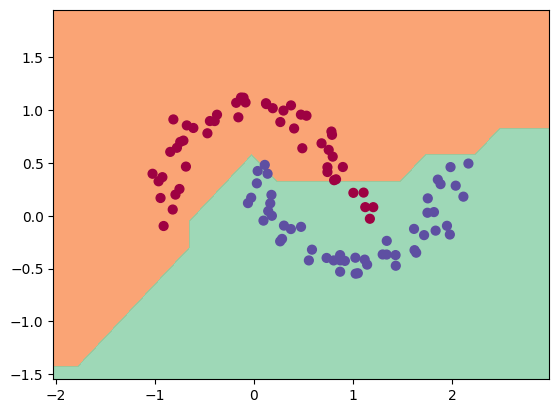

In [15]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())